In [4]:
# === Install Dependencies ===
!pip install --upgrade transformers
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install bert_score
!pip install sentence-transformers
!pip install torch

# === Imports ===
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq, EvalPrediction
import pandas as pd
import evaluate
from bert_score import score
from sentence_transformers import SentenceTransformer, util
import torch
import torch.nn.functional as F
import numpy as np
import math
import gc
import os
import warnings

# === Suppress Warnings ===
warnings.filterwarnings("ignore", category=FutureWarning)

# === Set Environment Variable for Memory Management ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# === Clear GPU Memory Initially ===
torch.cuda.empty_cache()
gc.collect()

# === Memory Profiling ===
print(f"Initial - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# === Load Abstract-Summary Dataset ===
abstract_df = pd.read_csv("abstract_summaries_gptstyle.csv")[["text", "summary"]].dropna()
abstract_df = abstract_df[abstract_df["text"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
abstract_df = abstract_df[abstract_df["summary"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
abstract_df = abstract_df.rename(columns={"text": "input_text", "summary": "target_text"})
abstract_df["input_text"] = "summarize: " + abstract_df["input_text"]

# === Load Q&A Dataset ===
qa_df = pd.read_csv("qanda.csv", encoding='latin-1')[["Question", "Answer"]].dropna()
qa_df = qa_df[qa_df["Question"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
qa_df = qa_df[qa_df["Answer"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
qa_df = qa_df.rename(columns={"Question": "input_text", "Answer": "target_text"})
qa_df["input_text"] = "question: " + qa_df["input_text"]

# === Combine Both Datasets ===
combined_df = pd.concat([abstract_df, qa_df], ignore_index=True)
dataset = Dataset.from_pandas(combined_df)

# === Split Dataset into Train and Test ===
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# === Clean Up Temporary Variables ===
del abstract_df, qa_df, combined_df, dataset
gc.collect()

# === Clear GPU Memory After Data Loading ===
torch.cuda.empty_cache()
gc.collect()
print(f"After data loading - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# === Load Tokenizer ===
model_name = "sshleifer/distilbart-cnn-6-6"  # DistilBART for sequence-to-sequence tasks
tokenizer = BartTokenizer.from_pretrained(model_name)

# === Preprocess Function ===
def preprocess(examples):
    # Ensure inputs and targets are valid strings
    inputs = [str(text) for text in examples["input_text"] if text and isinstance(text, str)]
    targets = [str(text) for text in examples["target_text"] if text and isinstance(text, str)]

    inputs = tokenizer(
        inputs,
        truncation=True,
        padding="max_length",
        max_length=128,  # Memory-efficient
        return_tensors="pt"  # Ensure PyTorch tensors
    )
    targets = tokenizer(
        targets,
        truncation=True,
        padding="max_length",
        max_length=32,   # Memory-efficient
        return_tensors="pt"
    )
    inputs["labels"] = targets["input_ids"]
    # Replace padding token id in labels with -100 for loss calculation
    inputs["labels"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in inputs["labels"]
    ]
    # Validate token IDs
    for i, label in enumerate(inputs["labels"]):
        for token_id in label:
            if token_id != -100 and (token_id < 0 or token_id >= tokenizer.vocab_size):
                print(f"Invalid token ID {token_id} in labels at index {i}")
                inputs["labels"][i] = [-100] * len(inputs["labels"][i])  # Replace invalid sequence

    # Convert to lists for Dataset compatibility
    return {
        "input_ids": inputs["input_ids"].tolist(),
        "attention_mask": inputs["attention_mask"].tolist(),
        "labels": inputs["labels"]
    }

train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["input_text", "target_text"])
test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["input_text", "target_text"])

# === Convert Dataset to Tensors ===
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# === Debug Dataset Structure ===
print("Sample test_dataset entry:", test_dataset[0])
print("test_dataset features:", test_dataset.features)
print("test_dataset input_ids type:", type(test_dataset[0]['input_ids']))
print("test_dataset labels type:", type(test_dataset[0]['labels']))

# === Validate Dataset ===
for i, example in enumerate(test_dataset):
    if not isinstance(example['input_ids'], torch.Tensor):
        print(f"Invalid input_ids at index {i}: {type(example['input_ids'])}")
    if not isinstance(example['labels'], torch.Tensor):
        print(f"Invalid labels at index {i}: {type(example['labels'])}")
    if example['input_ids'].ndim != 1:
        print(f"Invalid input_ids shape at index {i}: {example['input_ids'].shape}")
    if example['labels'].ndim != 1:
        print(f"Invalid labels shape at index {i}: {example['labels'].shape}")

# === Clear Memory After Preprocessing ===
torch.cuda.empty_cache()
gc.collect()
print(f"After preprocessing - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# === Load Model ===
model = BartForConditionalGeneration.from_pretrained(model_name)  # FP32, fp16 handles mixed precision
model.gradient_checkpointing_enable()  # Reduce activation memory

# === Move Model to GPU ===
model = model.to('cuda')
print(f"After model loading - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# === ROUGE Metric ===
rouge = evaluate.load("rouge")
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    # Handle padded predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in labels with pad_token_id for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return rouge.compute(predictions=decoded_preds, references=decoded_labels)

# === Custom Trainer for Generation ===
class CustomBartTrainer(Trainer):
    def predict(self, test_dataset, ignore_keys=None):
        self.model.eval()
        data_loader = self.get_eval_dataloader(test_dataset)
        predictions = []
        labels = []
        max_length = 32  # Match tokenizer max_length

        for batch in data_loader:
            input_ids = batch['input_ids'].to(self.model.device)
            attention_mask = batch['attention_mask'].to(self.model.device)
            batch_labels = batch['labels'].to(self.model.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=max_length,
                    num_beams=4,
                    early_stopping=True
                )
            # Pad outputs to max_length
            padded_outputs = torch.nn.functional.pad(
                outputs,
                (0, max_length - outputs.size(1)),
                value=tokenizer.pad_token_id
            )
            predictions.extend(padded_outputs.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

            # Debug sequence lengths
            print(f"Batch output lengths: {[len(seq) for seq in outputs.cpu().numpy()]}")
            print(f"Padded output shape: {padded_outputs.shape}")

            del input_ids, attention_mask, batch_labels, outputs, padded_outputs
            torch.cuda.empty_cache()
            gc.collect()

        # Convert to arrays for output
        predictions = np.array(predictions)  # Shape: (220, 32)
        labels = np.array(labels)  # Shape: (220, 32)

        # Compute metrics
        metrics = self.compute_metrics(EvalPrediction(predictions=predictions, label_ids=labels))

        # Return tuple instead of PredictionOutput
        return (predictions, labels, metrics)

# === Training Arguments ===
training_args = TrainingArguments(
    output_dir="./distilbart-multitask-finetuned",
    per_device_train_batch_size=2,  # Memory-efficient
    per_device_eval_batch_size=2,   # Memory-efficient
    gradient_accumulation_steps=2,   # Effective batch size of 4
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="no",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    fp16=True,
    gradient_checkpointing=True
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="pt")

# === Trainer ===
trainer = CustomBartTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# === Clear GPU Memory Before Training ===
torch.cuda.empty_cache()
gc.collect()
print(f"Before training - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# === 🚀 Train the Model ===
trainer.train()

# === 💾 Save Model & Tokenizer ===
model.save_pretrained("./distilbart-multitask-finetuned")
tokenizer.save_pretrained("./distilbart-multitask-finetuned")
print(f"After training - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# === 📊 Evaluation Phase ===
torch.cuda.empty_cache()
gc.collect()
print(f"Before evaluation - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# Generate predictions on test dataset
predictions = trainer.predict(test_dataset)

# Debug predictions structure
print("predictions type:", type(predictions))
print("predictions[0] shape:", np.shape(predictions[0]))
print("predictions[1] shape:", np.shape(predictions[1]))
print("predictions[2] type:", type(predictions[2]))
print("First prediction sample:", predictions[0][0])

# Handle potential nested or logit outputs
if isinstance(predictions[0], list):
    predictions[0] = np.array(predictions[0])
elif len(predictions[0].shape) == 3:  # Logits: (num_examples, seq_len, vocab_size)
    predictions[0] = np.argmax(predictions[0], axis=-1)

# Replace -100 with pad_token_id for decoding and validate token IDs
labels = np.where(predictions[1] != -100, predictions[1], tokenizer.pad_token_id)
for i, seq in enumerate(labels):
    if any(token_id >= tokenizer.vocab_size or token_id < 0 for token_id in seq):
        print(f"Invalid token IDs in labels at index {i}: {seq}")
        labels[i] = [tokenizer.pad_token_id] * len(seq)

decoded_preds = tokenizer.batch_decode(predictions[0], skip_special_tokens=True)
try:
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
except TypeError as e:
    print(f"Decoding error: {e}")
    decoded_labels = []
    for i, seq in enumerate(labels):
        try:
            decoded = tokenizer.decode(seq, skip_special_tokens=True)
            decoded_labels.append(decoded)
        except Exception as e:
            print(f"Failed to decode sequence {i}: {seq}, Error: {e}")
            decoded_labels.append("")
print(f"After evaluation - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

# --- ROUGE ---
print("\n🔍 ROUGE Results:")
rouge_results = predictions[2]  # Metrics from predict
for k, v in rouge_results.items():
    print(f"{k}: {v:.4f}")

# --- BERTScore ---
print("\n🧠 BERTScore Results:")
P, R, F1 = score(decoded_preds, decoded_labels, lang="en", verbose=True)
print(f"Precision: {P.mean().item():.4f}")
print(f"Recall:    {R.mean().item():.4f}")
print(f"F1 Score:  {F1.mean().item():.4f}")

# --- Cosine Similarity ---
print("\n🔗 Cosine Similarity Results:")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
pred_embeddings = embedding_model.encode(decoded_preds, convert_to_tensor=True)
label_embeddings = embedding_model.encode(decoded_labels, convert_to_tensor=True)
cosine_similarities = util.cos_sim(pred_embeddings, label_embeddings)
mean_cosine_sim = cosine_similarities.diag().mean().item()
print(f"Average Cosine Similarity: {mean_cosine_sim:.4f}")

# --- Perplexity ---
print("\n📉 Perplexity (lower is better):")
def calculate_perplexity(model, dataset):
    model.eval()
    losses = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=2)  # Memory-efficient
    for batch in data_loader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            losses.append(loss.item())

        del input_ids, attention_mask, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    return math.exp(sum(losses) / len(losses))

# Clear memory before perplexity calculation
torch.cuda.empty_cache()
gc.collect()
print(f"Before perplexity - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

ppl = calculate_perplexity(model, test_dataset)
print(f"Perplexity: {ppl:.4f}")

# === Final Memory Check ===
torch.cuda.empty_cache()
gc.collect()
print(f"Final - Allocated: {torch.cuda.memory_allocated() / 1024*3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024*3:.2f} GiB")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5f0079d0577fe26e930ff156f2dae9da8c1fc9e09f090b6bb11c3c9c05da1754
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Initial - Allocated: 0.00 GiB, Reserved: 0.00 GiB
After data loading - Allocated: 0.00 GiB, Reserved: 0.00 GiB


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Sample test_dataset entry: {'input_ids': tensor([    0, 40018,    35,  2612,   109,  2292,   246, 14770,  1630, 44318,
         2849,   462,  2611,  6355,   712,     5,  2375,  2862,     9,  1427,
         9816,   116,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,  

pytorch_model.bin:   0%|          | 0.00/460M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/460M [00:00<?, ?B/s]

After model loading - Allocated: 2695117.50 GiB, Reserved: 2709504.00 GiB
Before training - Allocated: 2695117.50 GiB, Reserved: 2709504.00 GiB


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Step,Training Loss
10,3.825000
20,3.468900
30,3.630300
40,3.428200
50,3.107800
60,3.108900
70,3.063600
80,2.986300
90,3.101800
100,2.920000


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


After training - Allocated: 8134096.50 GiB, Reserved: 13707264.00 GiB
Before evaluation - Allocated: 8134096.50 GiB, Reserved: 8251392.00 GiB


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1570: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (32). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([2, 32])
Batch output lengths: [32, 32]
Padded output shape: torch.Size([

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 2.18 seconds, 100.94 sentences/sec
Precision: 0.8693
Recall:    0.8973
F1 Score:  0.8829

🔗 Cosine Similarity Results:


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Average Cosine Similarity: 0.5727

📉 Perplexity (lower is better):
Before perplexity - Allocated: 8402839.50 GiB, Reserved: 8540160.00 GiB
Perplexity: 28.3280
Final - Allocated: 8402839.50 GiB, Reserved: 8540160.00 GiB


In [5]:
# === Print Sample Predictions ===
# Adjust indices to match test dataset and ensure Q&A subset
print("\n📝 Sample 5 Predictions vs References:\n")
qa_test_indices = [i for i, example in enumerate(test_dataset) if example['input_ids'][0] in tokenizer.encode("question:")]
for i in range(min(5, len(qa_test_indices))):
    idx = qa_test_indices[i]
    # Decode input from test_dataset to remove "question:" prefix for clarity
    input_text = tokenizer.decode(test_dataset[idx]['input_ids'], skip_special_tokens=True).replace("question: ", "")
    print(f"Q{i+1}: {input_text}")
    print(f"Model Answer: {decoded_preds[idx]}")
    print(f"Actual Answer: {decoded_labels[idx]}\n")


📝 Sample 5 Predictions vs References:

Q1: Why do sp3 nanodiamond sublattices increase the effective mass of charge carriers?
Model Answer: Sp3 nanodiamond sublattices significantly lower the energy gap and amplify charge carrier interactions, increasing the effective mass of charge carriers around the
Actual Answer: Sp3 sublattices confine electrons, increasing effective mass via structural distortion.

Q2: What role does copolymerization play in photolithographic patterning?
Model Answer: Its critical for achieving uniform photolithographic patterning properties like cellulose bond strength and resistance to environmental conditions like Ni(
Actual Answer: It enables photolithographic structuring of fluorozwitterist films.

Q3: How does twisting GNRs alter their thermal conductivity (TC)?
Model Answer: Twist twisting GNRs alters thermal conductivity (TC) and resistance to the Fermi energy gap (NTE). twisting GN
Actual Answer: Twisting modifies phonon scattering, altering TC in TGNR

In [6]:
# === Imports ===
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
import evaluate
from bert_score import score
from sentence_transformers import SentenceTransformer, util
import math
import pandas as pd
import gc
import os

# === Set Environment Variable for Memory Management ===
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# === Clear GPU Memory Initially ===
torch.cuda.empty_cache()
gc.collect()
print(f"Initial - Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")

# === Verify Model Directory ===
model_path = "./distilbart-multitask-finetuned"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model directory {model_path} not found. Please ensure the fine-tuned DistilBART model is saved in {model_path} or re-run the training script.")

# === Load Models and Tokenizers ===
print("Loading fine-tuned DistilBART model...")
try:
    tokenizer_finetuned = BartTokenizer.from_pretrained(model_path)
    model_finetuned = BartForConditionalGeneration.from_pretrained(model_path)
    model_finetuned = model_finetuned.to('cuda')
    model_finetuned.eval()
except Exception as e:
    print(f"Error loading fine-tuned model: {e}")
    raise

print("Loading pre-trained DistilBART model...")
tokenizer_pretrained = BartTokenizer.from_pretrained("sshleifer/distilbart-cnn-6-6")
model_pretrained = BartForConditionalGeneration.from_pretrained("sshleifer/distilbart-cnn-6-6")
model_pretrained = model_pretrained.to('cuda')
model_pretrained.eval()
print(f"After model loading - Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")

# === Load and Preprocess 1000 Q&A Pairs ===
print("Loading and preprocessing Q&A dataset...")
try:
    qa_df = pd.read_csv("qanda.csv", encoding='latin-1')[["Question", "Answer"]].dropna()
except FileNotFoundError:
    print("Error: qanda.csv not found in /content. Please upload the file.")
    raise
qa_df = qa_df[qa_df["Question"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
qa_df = qa_df[qa_df["Answer"].apply(lambda x: isinstance(x, str) and len(x.strip()) > 0)]
qa_df = qa_df.rename(columns={"Question": "input_text", "Answer": "target_text"})
qa_df["input_text"] = "question: " + qa_df["input_text"]

# Check dataset size
print(f"Number of valid Q&A pairs: {len(qa_df)}")
if len(qa_df) < 1000:
    print(f"Warning: Dataset contains only {len(qa_df)} valid Q&A pairs, using all available pairs.")
    qa_df = qa_df.sample(n=len(qa_df), random_state=42).reset_index(drop=True)
else:
    qa_df = qa_df.sample(n=1000, random_state=42).reset_index(drop=True)
print(f"Selected {len(qa_df)} Q&A pairs for evaluation.")

# === Preprocess Function ===
def preprocess_data(df, tokenizer, batch_size=32):
    print(f"Preprocessing data with batch size {batch_size}...")
    inputs = []
    attention_masks = []
    labels = []

    for i in range(0, len(df), batch_size):
        batch_inputs = df["input_text"].iloc[i:i+batch_size].tolist()
        batch_targets = df["target_text"].iloc[i:i+batch_size].tolist()

        batch_encoded_inputs = tokenizer(
            batch_inputs,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        batch_encoded_targets = tokenizer(
            batch_targets,
            truncation=True,
            padding="max_length",
            max_length=32,
            return_tensors="pt"
        )

        inputs.append(batch_encoded_inputs["input_ids"])
        attention_masks.append(batch_encoded_inputs["attention_mask"])
        labels.append(batch_encoded_targets["input_ids"])

        del batch_encoded_inputs, batch_encoded_targets
        gc.collect()
        print(f"Preprocessed batch {i//batch_size + 1}/{math.ceil(len(df)/batch_size)}")

    inputs = torch.cat(inputs, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.cat(labels, dim=0)

    return {
        "input_ids": inputs,
        "attention_mask": attention_masks,
        "labels": labels
    }

# Preprocess data
print("Preprocessing for fine-tuned DistilBART model...")
processed_data_finetuned = preprocess_data(qa_df, tokenizer_finetuned)
print("Preprocessing for pre-trained DistilBART model...")
processed_data_pretrained = preprocess_data(qa_df, tokenizer_pretrained)

# Move data to GPU
print("Moving data to GPU...")
processed_data_finetuned = {k: v.to('cuda') for k, v in processed_data_finetuned.items()}
processed_data_pretrained = {k: v.to('cuda') for k, v in processed_data_pretrained.items()}
print(f"After preprocessing - Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")

# === Function for Prediction Generation ===
def generate_predictions(model, tokenizer, processed_data, batch_size=4, max_length=32):
    print(f"Generating predictions with batch size {batch_size}...")
    predictions = []
    total_batches = math.ceil(len(qa_df) / batch_size)

    for i in range(0, len(qa_df), batch_size):
        batch_inputs = processed_data["input_ids"][i:i+batch_size]
        batch_attention = processed_data["attention_mask"][i:i+batch_size]

        try:
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=batch_inputs,
                    attention_mask=batch_attention,
                    max_length=max_length,
                    num_beams=4,
                    early_stopping=True
                )
            decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            predictions.extend(decoded_outputs)

            del batch_inputs, batch_attention, outputs
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Processed batch {i//batch_size + 1}/{total_batches} ({len(predictions)}/{len(qa_df)} pairs)")
        except RuntimeError as e:
            print(f"Error in batch {i//batch_size + 1}: {e}")
            raise

    return predictions

# Generate predictions
print("Generating predictions for fine-tuned DistilBART model...")
predictions_finetuned = generate_predictions(model_finetuned, tokenizer_finetuned, processed_data_finetuned)
print("Generating predictions for pre-trained DistilBART model...")
predictions_pretrained = generate_predictions(model_pretrained, tokenizer_pretrained, processed_data_pretrained)

# Decode labels
print("Decoding ground truth labels...")
decoded_labels = tokenizer_finetuned.batch_decode(processed_data_finetuned["labels"], skip_special_tokens=True)
print(f"Generated {len(predictions_finetuned)} predictions for fine-tuned model, {len(predictions_pretrained)} for pre-trained model, and {len(decoded_labels)} labels.")

# === Evaluation Metrics ===

# --- ROUGE ---
print("\n🔍 Computing ROUGE scores...")
rouge = evaluate.load("rouge")
rouge_results_finetuned = rouge.compute(predictions=predictions_finetuned, references=decoded_labels)
rouge_results_pretrained = rouge.compute(predictions=predictions_pretrained, references=decoded_labels)

print("\n🔍 ROUGE Results (Fine-tuned DistilBART Model):")
for k, v in rouge_results_finetuned.items():
    print(f"{k}: {v:.4f}")

print("\n🔍 ROUGE Results (Pre-trained DistilBART Model):")
for k, v in rouge_results_pretrained.items():
    print(f"{k}: {v:.4f}")

# --- BERTScore ---
print("\n🧠 Computing BERTScore...")
try:
    P_finetuned, R_finetuned, F1_finetuned = score(predictions_finetuned, decoded_labels, lang="en", model_type="distilbert-base-uncased", verbose=True)
    P_pretrained, R_pretrained, F1_pretrained = score(predictions_pretrained, decoded_labels, lang="en", model_type="distilbert-base-uncased", verbose=True)

    print(f"\nFine-tuned DistilBART Model - Precision: {P_finetuned.mean().item():.4f}, Recall: {R_finetuned.mean().item():.4f}, F1 Score: {F1_finetuned.mean().item():.4f}")
    print(f"Pre-trained DistilBART Model - Precision: {P_pretrained.mean().item():.4f}, Recall: {R_pretrained.mean().item():.4f}, F1 Score: {F1_pretrained.mean().item():.4f}")
except Exception as e:
    print(f"Error computing BERTScore: {e}")

# --- Cosine Similarity ---
print("\n🔗 Computing Cosine Similarity...")
try:
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    pred_embeddings_finetuned = embedding_model.encode(predictions_finetuned, convert_to_tensor=True)
    pred_embeddings_pretrained = embedding_model.encode(predictions_pretrained, convert_to_tensor=True)
    label_embeddings = embedding_model.encode(decoded_labels, convert_to_tensor=True)

    cosine_sim_finetuned = util.cos_sim(pred_embeddings_finetuned, label_embeddings)
    cosine_sim_pretrained = util.cos_sim(pred_embeddings_pretrained, label_embeddings)

    mean_cosine_sim_finetuned = cosine_sim_finetuned.diag().mean().item()
    mean_cosine_sim_pretrained = cosine_sim_pretrained.diag().mean().item()

    print(f"Fine-tuned DistilBART Model - Average Cosine Similarity: {mean_cosine_sim_finetuned:.4f}")
    print(f"Pre-trained DistilBART Model - Average Cosine Similarity: {mean_cosine_sim_pretrained:.4f}")
except Exception as e:
    print(f"Error computing Cosine Similarity: {e}")

# --- Perplexity ---
print("\n📉 Computing Perplexity...")
def calculate_perplexity(model, input_ids, attention_mask, labels, batch_size=4):
    model.eval()
    losses = []
    total_batches = math.ceil(len(input_ids) / batch_size)

    for i in range(0, len(input_ids), batch_size):
        batch_inputs = input_ids[i:i+batch_size]
        batch_attention = attention_mask[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        try:
            with torch.no_grad():
                outputs = model(
                    input_ids=batch_inputs,
                    attention_mask=batch_attention,
                    labels=batch_labels
                )
                losses.append(outputs.loss.item())

            del batch_inputs, batch_attention, batch_labels, outputs
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Perplexity batch {i//batch_size + 1}/{total_batches}")
        except RuntimeError as e:
            print(f"Error in perplexity batch {i//batch_size + 1}: {e}")
            raise

    return math.exp(sum(losses) / len(losses))

try:
    ppl_finetuned = calculate_perplexity(
        model_finetuned,
        processed_data_finetuned["input_ids"],
        processed_data_finetuned["attention_mask"],
        processed_data_finetuned["labels"]
    )
    ppl_pretrained = calculate_perplexity(
        model_pretrained,
        processed_data_pretrained["input_ids"],
        processed_data_pretrained["attention_mask"],
        processed_data_pretrained["labels"]
    )

    print(f"Fine-tuned DistilBART Model Perplexity: {ppl_finetuned:.4f}")
    print(f"Pre-trained DistilBART Model Perplexity: {ppl_pretrained:.4f}")
except Exception as e:
    print(f"Error computing Perplexity: {e}")

# === Save Results ===
print("\n💾 Saving evaluation results...")
results = {
    "rouge_finetuned": rouge_results_finetuned,
    "rouge_pretrained": rouge_results_pretrained,
    "bertscore_finetuned": {"P": P_finetuned.mean().item() if 'P_finetuned' in locals() else None,
                           "R": R_finetuned.mean().item() if 'R_finetuned' in locals() else None,
                           "F1": F1_finetuned.mean().item() if 'F1_finetuned' in locals() else None},
    "bertscore_pretrained": {"P": P_pretrained.mean().item() if 'P_pretrained' in locals() else None,
                            "R": R_pretrained.mean().item() if 'R_pretrained' in locals() else None,
                            "F1": F1_pretrained.mean().item() if 'F1_pretrained' in locals() else None},
    "cosine_sim_finetuned": mean_cosine_sim_finetuned if 'mean_cosine_sim_finetuned' in locals() else None,
    "cosine_sim_pretrained": mean_cosine_sim_pretrained if 'mean_cosine_sim_pretrained' in locals() else None,
    "perplexity_finetuned": ppl_finetuned if 'ppl_finetuned' in locals() else None,
    "perplexity_pretrained": ppl_pretrained if 'ppl_pretrained' in locals() else None
}

import json
with open("/content/distilbart_evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to /content/distilbart_evaluation_results.json")

# === Final Memory Check ===
torch.cuda.empty_cache()
gc.collect()
print(f"Final - Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")

Initial - Allocated: 2.67 GiB, Reserved: 2.71 GiB
Loading fine-tuned DistilBART model...


/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Loading pre-trained DistilBART model...
After model loading - Allocated: 4.38 GiB, Reserved: 4.40 GiB
Loading and preprocessing Q&A dataset...
Number of valid Q&A pairs: 1000
Selected 1000 Q&A pairs for evaluation.
Preprocessing for fine-tuned DistilBART model...
Preprocessing data with batch size 32...
Preprocessed batch 1/32
Preprocessed batch 2/32
Preprocessed batch 3/32
Preprocessed batch 4/32
Preprocessed batch 5/32
Preprocessed batch 6/32
Preprocessed batch 7/32
Preprocessed batch 8/32
Preprocessed batch 9/32
Preprocessed batch 10/32
Preprocessed batch 11/32
Preprocessed batch 12/32
Preprocessed batch 13/32
Preprocessed batch 14/32
Preprocessed batch 15/32
Preprocessed batch 16/32
Preprocessed batch 17/32
Preprocessed batch 18/32
Preprocessed batch 19/32
Preprocessed batch 20/32
Preprocessed batch 21/32
Preprocessed batch 22/32
Preprocessed batch 23/32
Preprocessed batch 24/32
Preprocessed batch 25/32
Preprocessed batch 26/32
Preprocessed batch 27/32
Preprocessed batch 28/32
Prep

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Processed batch 1/250 (4/1000 pairs)
Processed batch 2/250 (8/1000 pairs)
Processed batch 3/250 (12/1000 pairs)
Processed batch 4/250 (16/1000 pairs)
Processed batch 5/250 (20/1000 pairs)
Processed batch 6/250 (24/1000 pairs)
Processed batch 7/250 (28/1000 pairs)
Processed batch 8/250 (32/1000 pairs)
Processed batch 9/250 (36/1000 pairs)
Processed batch 10/250 (40/1000 pairs)
Processed batch 11/250 (44/1000 pairs)
Processed batch 12/250 (48/1000 pairs)
Processed batch 13/250 (52/1000 pairs)
Processed batch 14/250 (56/1000 pairs)
Processed batch 15/250 (60/1000 pairs)
Processed batch 16/250 (64/1000 pairs)
Processed batch 17/250 (68/1000 pairs)
Processed batch 18/250 (72/1000 pairs)
Processed batch 19/250 (76/1000 pairs)
Processed batch 20/250 (80/1000 pairs)
Processed batch 21/250 (84/1000 pairs)
Processed batch 22/250 (88/1000 pairs)
Processed batch 23/250 (92/1000 pairs)
Processed batch 24/250 (96/1000 pairs)
Processed batch 25/250 (100/1000 pairs)
Processed batch 26/250 (104/1000 pa

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1570: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (32). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


Processed batch 1/250 (4/1000 pairs)
Processed batch 2/250 (8/1000 pairs)
Processed batch 3/250 (12/1000 pairs)
Processed batch 4/250 (16/1000 pairs)
Processed batch 5/250 (20/1000 pairs)
Processed batch 6/250 (24/1000 pairs)
Processed batch 7/250 (28/1000 pairs)
Processed batch 8/250 (32/1000 pairs)
Processed batch 9/250 (36/1000 pairs)
Processed batch 10/250 (40/1000 pairs)
Processed batch 11/250 (44/1000 pairs)
Processed batch 12/250 (48/1000 pairs)
Processed batch 13/250 (52/1000 pairs)
Processed batch 14/250 (56/1000 pairs)
Processed batch 15/250 (60/1000 pairs)
Processed batch 16/250 (64/1000 pairs)
Processed batch 17/250 (68/1000 pairs)
Processed batch 18/250 (72/1000 pairs)
Processed batch 19/250 (76/1000 pairs)
Processed batch 20/250 (80/1000 pairs)
Processed batch 21/250 (84/1000 pairs)
Processed batch 22/250 (88/1000 pairs)
Processed batch 23/250 (92/1000 pairs)
Processed batch 24/250 (96/1000 pairs)
Processed batch 25/250 (100/1000 pairs)
Processed batch 26/250 (104/1000 pa

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/23 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 1.74 seconds, 574.83 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/32 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/16 [00:00<?, ?it/s]

done in 2.51 seconds, 398.87 sentences/sec

Fine-tuned DistilBART Model - Precision: 0.8747, Recall: 0.8688, F1 Score: 0.8715
Pre-trained DistilBART Model - Precision: 0.7558, Recall: 0.8048, F1 Score: 0.7791

🔗 Computing Cosine Similarity...
Fine-tuned DistilBART Model - Average Cosine Similarity: 0.7715
Pre-trained DistilBART Model - Average Cosine Similarity: 0.5575

📉 Computing Perplexity...
Perplexity batch 1/250
Perplexity batch 2/250
Perplexity batch 3/250
Perplexity batch 4/250
Perplexity batch 5/250
Perplexity batch 6/250
Perplexity batch 7/250
Perplexity batch 8/250
Perplexity batch 9/250
Perplexity batch 10/250
Perplexity batch 11/250
Perplexity batch 12/250
Perplexity batch 13/250
Perplexity batch 14/250
Perplexity batch 15/250
Perplexity batch 16/250
Perplexity batch 17/250
Perplexity batch 18/250
Perplexity batch 19/250
Perplexity batch 20/250
Perplexity batch 21/250
Perplexity batch 22/250
Perplexity batch 23/250
Perplexity batch 24/250
Perplexity batch 25/250
Perplexity

In [7]:
# === Install tabulate for Tabulated Output ===
!pip install tabulate

# === Import tabulate ===
from tabulate import tabulate

# === Tabulated Output ===
print("\n📊 Evaluation Results (Tabulated Format):")
table_data = [
    ["ROUGE-1",
     f"{rouge_results_finetuned['rouge1']:.4f}" if rouge_results_finetuned else "N/A",
     f"{rouge_results_pretrained['rouge1']:.4f}" if rouge_results_pretrained else "N/A"],
    ["ROUGE-2",
     f"{rouge_results_finetuned['rouge2']:.4f}" if rouge_results_finetuned else "N/A",
     f"{rouge_results_pretrained['rouge2']:.4f}" if rouge_results_pretrained else "N/A"],
    ["ROUGE-L",
     f"{rouge_results_finetuned['rougeL']:.4f}" if rouge_results_finetuned else "N/A",
     f"{rouge_results_pretrained['rougeL']:.4f}" if rouge_results_pretrained else "N/A"],
    ["ROUGE-Lsum",
     f"{rouge_results_finetuned['rougeLsum']:.4f}" if rouge_results_finetuned else "N/A",
     f"{rouge_results_pretrained['rougeLsum']:.4f}" if rouge_results_pretrained else "N/A"],
    ["BERTScore Precision",
     f"{P_finetuned.mean().item():.4f}" if P_finetuned is not None else "N/A",
     f"{P_pretrained.mean().item():.4f}" if P_pretrained is not None else "N/A"],
    ["BERTScore Recall",
     f"{R_finetuned.mean().item():.4f}" if R_finetuned is not None else "N/A",
     f"{R_pretrained.mean().item():.4f}" if R_pretrained is not None else "N/A"],
    ["BERTScore F1",
     f"{F1_finetuned.mean().item():.4f}" if F1_finetuned is not None else "N/A",
     f"{F1_pretrained.mean().item():.4f}" if F1_pretrained is not None else "N/A"],
    ["Cosine Similarity",
     f"{mean_cosine_sim_finetuned:.4f}" if mean_cosine_sim_finetuned is not None else "N/A",
     f"{mean_cosine_sim_pretrained:.4f}" if mean_cosine_sim_pretrained is not None else "N/A"],
    ["Perplexity",
     f"{ppl_finetuned:.4f}" if ppl_finetuned is not None else "N/A",
     f"{ppl_pretrained:.4f}" if ppl_pretrained is not None else "N/A"]
]

headers = ["Metric", "Fine-tuned DistilBART", "Pre-trained DistilBART"]
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

# === Save Results ===
print("\n💾 Saving evaluation results...")
results = {
    "rouge_finetuned": rouge_results_finetuned,
    "rouge_pretrained": rouge_results_pretrained,
    "bertscore_finetuned": {"P": P_finetuned.mean().item() if 'P_finetuned' in locals() else None,
                           "R": R_finetuned.mean().item() if 'R_finetuned' in locals() else None,
                           "F1": F1_finetuned.mean().item() if 'F1_finetuned' in locals() else None},
    "bertscore_pretrained": {"P": P_pretrained.mean().item() if 'P_pretrained' in locals() else None,
                            "R": R_pretrained.mean().item() if 'R_pretrained' in locals() else None,
                            "F1": F1_pretrained.mean().item() if 'F1_pretrained' in locals() else None},
    "cosine_sim_finetuned": mean_cosine_sim_finetuned if 'mean_cosine_sim_finetuned' in locals() else None,
    "cosine_sim_pretrained": mean_cosine_sim_pretrained if 'mean_cosine_sim_pretrained' in locals() else None,
    "perplexity_finetuned": ppl_finetuned if 'ppl_finetuned' in locals() else None,
    "perplexity_pretrained": ppl_pretrained if 'ppl_pretrained' in locals() else None
}

with open("/content/distilbart_evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Results saved to /content/distilbart_evaluation_results.json")

# === Final Memory Check ===
torch.cuda.empty_cache()
gc.collect()
print(f"Final - Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GiB, Reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GiB")


📊 Evaluation Results (Tabulated Format):
╒═════════════════════╤═════════════════════════╤══════════════════════════╕
│ Metric              │   Fine-tuned DistilBART │   Pre-trained DistilBART │
╞═════════════════════╪═════════════════════════╪══════════════════════════╡
│ ROUGE-1             │                  0.6952 │                   0.2211 │
├─────────────────────┼─────────────────────────┼──────────────────────────┤
│ ROUGE-2             │                  0.6304 │                   0.0932 │
├─────────────────────┼─────────────────────────┼──────────────────────────┤
│ ROUGE-L             │                  0.6844 │                   0.1984 │
├─────────────────────┼─────────────────────────┼──────────────────────────┤
│ ROUGE-Lsum          │                  0.686  │                   0.1985 │
├─────────────────────┼─────────────────────────┼──────────────────────────┤
│ BERTScore Precision │                  0.8747 │                   0.7558 │
├─────────────────────┼───────────

Computing per-example metrics...
Computing BERTScore...
Length of predictions_finetuned: 1000
Length of predictions_pretrained: 1000
Length of decoded_labels: 1000
Sample prediction (finetuned): ['']
Sample prediction (pretrained): ['question: Why does every third defective AGNR exhibit a zero-gap with Dirac-type crossings? The question is: Why do every third']
Sample label: ['Periodic defect alignment creates linear band crossings at the Fermi level.']
calculating scores...
computing bert embedding.


  0%|          | 0/45 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/32 [00:00<?, ?it/s]

done in 1.84 seconds, 542.87 sentences/sec
calculating scores...
computing bert embedding.


  0%|          | 0/63 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/32 [00:00<?, ?it/s]

done in 2.61 seconds, 382.84 sentences/sec
Computing Cosine Similarity...
Generating curve plots...


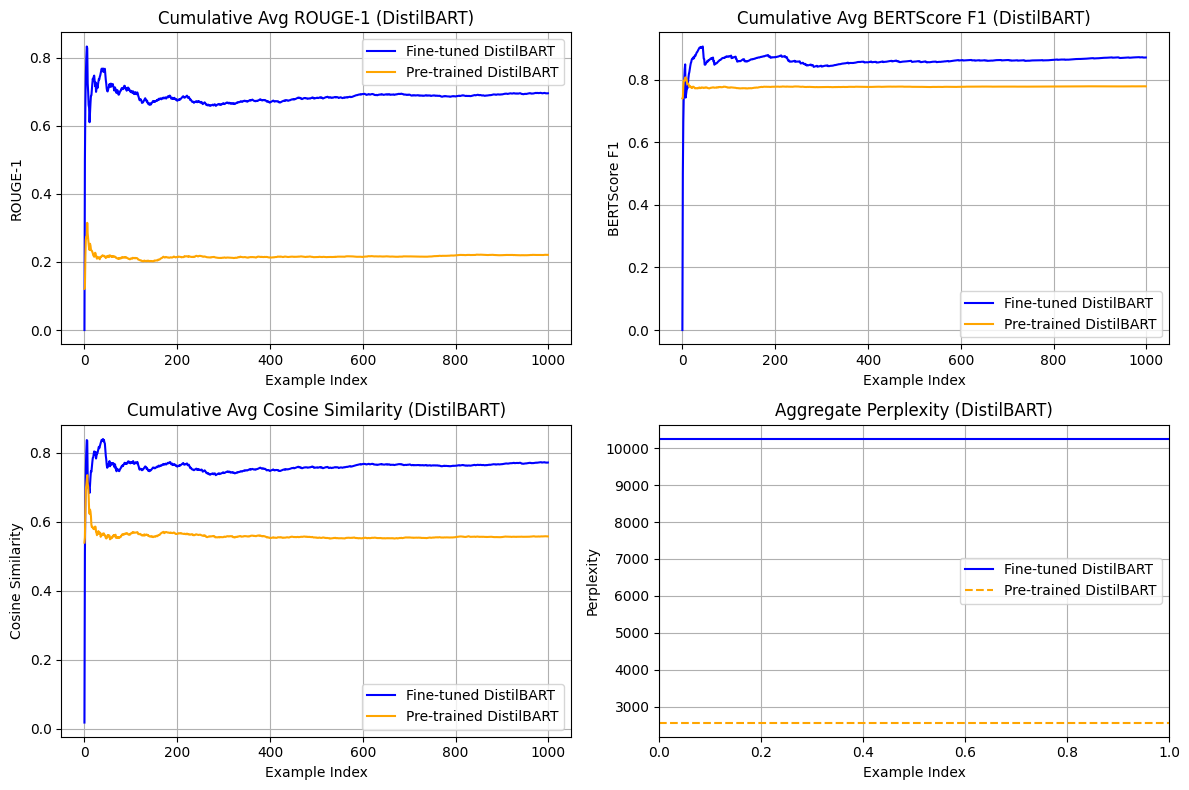

Plot saved to /content/distilbart_metric_curves.png


In [9]:
# === Install Dependencies ===
!pip install matplotlib evaluate bert_score sentence-transformers

# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from evaluate import load
from bert_score import score
from sentence_transformers import SentenceTransformer, util

# === Compute Per-Example Metrics ===
print("Computing per-example metrics...")

# ROUGE
rouge = load("rouge")
rouge1_finetuned = []
rouge1_pretrained = []
for pred_f, pred_p, ref in zip(predictions_finetuned, predictions_pretrained, decoded_labels):
    try:
        rouge_f = rouge.compute(predictions=[pred_f], references=[ref])['rouge1']
        rouge_p = rouge.compute(predictions=[pred_p], references=[ref])['rouge1']
        rouge1_finetuned.append(rouge_f)
        rouge1_pretrained.append(rouge_p)
    except Exception as e:
        print(f"Error computing ROUGE for example: {e}")
        rouge1_finetuned.append(np.nan)
        rouge1_pretrained.append(np.nan)

# BERTScore (batch processing for efficiency)
print("Computing BERTScore...")
try:
    # Debug: Check input validity
    print(f"Length of predictions_finetuned: {len(predictions_finetuned)}")
    print(f"Length of predictions_pretrained: {len(predictions_pretrained)}")
    print(f"Length of decoded_labels: {len(decoded_labels)}")
    print(f"Sample prediction (finetuned): {predictions_finetuned[:1]}")
    print(f"Sample prediction (pretrained): {predictions_pretrained[:1]}")
    print(f"Sample label: {decoded_labels[:1]}")

    P_f, R_f, F1_finetuned = score(
        predictions_finetuned,
        decoded_labels,
        lang="en",
        model_type="distilbert-base-uncased",
        batch_size=32,
        verbose=True
    )
    P_p, R_p, F1_pretrained = score(
        predictions_pretrained,
        decoded_labels,
        lang="en",
        model_type="distilbert-base-uncased",
        batch_size=32,
        verbose=True
    )
    F1_finetuned = F1_finetuned.numpy()
    F1_pretrained = F1_pretrained.numpy()
except Exception as e:
    print(f"Error computing BERTScore: {e}")
    F1_finetuned = [np.nan] * len(decoded_labels)
    F1_pretrained = [np.nan] * len(decoded_labels)

# Cosine Similarity
print("Computing Cosine Similarity...")
try:
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
    pred_embeddings_f = embedding_model.encode(predictions_finetuned, convert_to_tensor=True, batch_size=32)
    pred_embeddings_p = embedding_model.encode(predictions_pretrained, convert_to_tensor=True, batch_size=32)
    label_embeddings = embedding_model.encode(decoded_labels, convert_to_tensor=True, batch_size=32)
    cos_sim_finetuned = util.cos_sim(pred_embeddings_f, label_embeddings).diag().cpu().numpy()
    cos_sim_pretrained = util.cos_sim(pred_embeddings_p, label_embeddings).diag().cpu().numpy()
except Exception as e:
    print(f"Error computing Cosine Similarity: {e}")
    cos_sim_finetuned = [np.nan] * len(decoded_labels)
    cos_sim_pretrained = [np.nan] * len(decoded_labels)

# Perplexity (aggregate only, as per-example is slow)
ppl_finetuned = ppl_finetuned if 'ppl_finetuned' in globals() else np.nan
ppl_pretrained = ppl_pretrained if 'ppl_pretrained' in globals() else np.nan

# === Compute Cumulative Averages ===
def cumulative_avg(data):
    return np.cumsum(data) / np.arange(1, len(data) + 1)

cum_rouge1_f = cumulative_avg(rouge1_finetuned)
cum_rouge1_p = cumulative_avg(rouge1_pretrained)
cum_f1_f = cumulative_avg(F1_finetuned)
cum_f1_p = cumulative_avg(F1_pretrained)
cum_cos_f = cumulative_avg(cos_sim_finetuned)
cum_cos_p = cumulative_avg(cos_sim_pretrained)

# === Plot Curves ===
print("Generating curve plots...")
plt.figure(figsize=(12, 8))

# ROUGE-1
plt.subplot(2, 2, 1)
plt.plot(cum_rouge1_f, label='Fine-tuned DistilBART', color='blue')
plt.plot(cum_rouge1_p, label='Pre-trained DistilBART', color='orange')
plt.title('Cumulative Avg ROUGE-1 (DistilBART)')
plt.xlabel('Example Index')
plt.ylabel('ROUGE-1')
plt.legend()
plt.grid(True)

# BERTScore F1
plt.subplot(2, 2, 2)
plt.plot(cum_f1_f, label='Fine-tuned DistilBART', color='blue')
plt.plot(cum_f1_p, label='Pre-trained DistilBART', color='orange')
plt.title('Cumulative Avg BERTScore F1 (DistilBART)')
plt.xlabel('Example Index')
plt.ylabel('BERTScore F1')
plt.legend()
plt.grid(True)

# Cosine Similarity
plt.subplot(2, 2, 3)
plt.plot(cum_cos_f, label='Fine-tuned DistilBART', color='blue')
plt.plot(cum_cos_p, label='Pre-trained DistilBART', color='orange')
plt.title('Cumulative Avg Cosine Similarity (DistilBART)')
plt.xlabel('Example Index')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.grid(True)

# Perplexity (static lines)
plt.subplot(2, 2, 4)
plt.axhline(y=ppl_finetuned, label='Fine-tuned DistilBART', color='blue', linestyle='-')
plt.axhline(y=ppl_pretrained, label='Pre-trained DistilBART', color='orange', linestyle='--')
plt.title('Aggregate Perplexity (DistilBART)')
plt.xlabel('Example Index')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/distilbart_metric_curves.png')
plt.show()
print("Plot saved to /content/distilbart_metric_curves.png")